<a href="https://colab.research.google.com/github/Zyuuu-G/ML-classwork/blob/main/Machine_Learning_HW5_Neural_Network_OCR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dr. D.  
      Ziyu Gao
      

Class: PHYS453


# HW5 - Neural Network OCR
Clever and/or funny title goes here.

# Tasks
The best for last: for our final homework assignment you will train a neural network to recognize your own handwriting.  
1. Train an MLPClassifier on the digits dataset and find the expected accuracy (from test/train split)
1. Load in a scanned image of your handwriting for the digits 0-9
1. Demonstrate that your MLP can classify them with at least 50% accuracy, and discuss if your prediction accuracy is what you expected

# Bonus Tasks (for extra credit)
* Find the most similar digits in the dataset to your own handwriting
* How does the neural network perform relative to the other classifiers from HW4?    

# Notes
* No, I will **not** tell you how to read image files in python.  The greatest skill you can have is learning how to google, read documentation, and make code work.  This is vital to practice before tackling our final projects.   
* Don't forget to scale your data.  Both the digits dataset and your handwriting must be scaled the same way!



# import and clean data

In [ ]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


(2200, 1700)


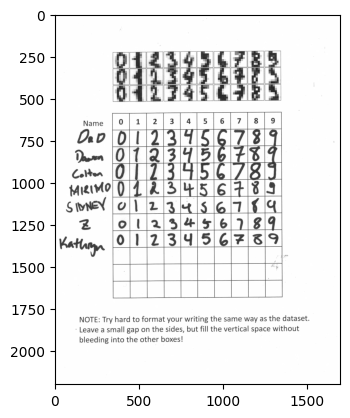

In [ ]:
img = cv2.imread('/content/drive/MyDrive/Photography/School/handwritting_scan.jpg',0) # (~~~,0) make it binary color
print(img.shape)
plt.imshow(img,cmap='gray')
plt.show()

In [ ]:
#img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#print(img.shape)
#plt.imshow(img,cmap='gray')
#plt.show()

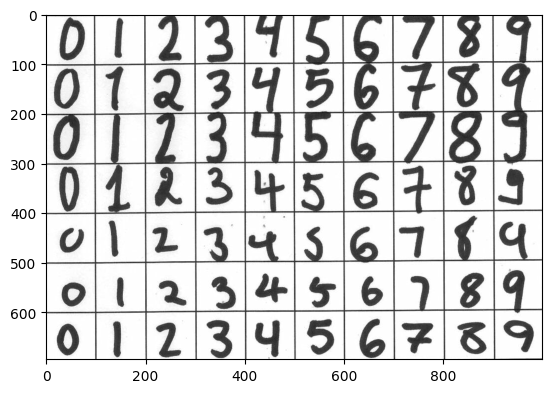

In [ ]:
# eyeball-find range of all data
plt.imshow(img[682+5:1382,345:1345],cmap='gray')

# the width and heigth of each cell are roughly 100 units

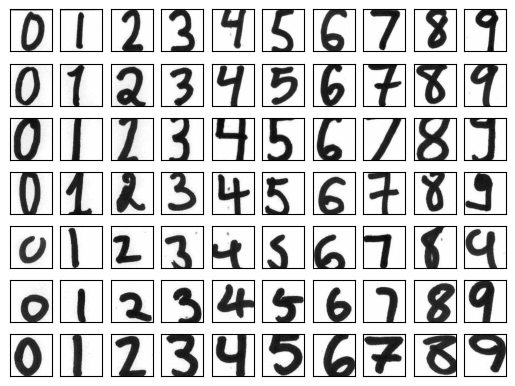

In [ ]:
# break down to individual cells and save it as a numpy array that has 70 items

#name = ['Dr.D','Dawson','Colton','Mirimo','Sidney','Ziyu','Kathryn']
extraRaw = []

for i in range(7):  # get rows
    for j in range(10):  # get columns for each row
      #hold = np.empty((90,90,3))
      hold = img[(682+100*i + 4+3*i):(682+100*(i+1) - 2-i),(345+100*j + 3+2*i):(345+100*(j+1) - 3-2*i)]
      #hold = img[(682+100*i + 5):(682+100*(i+1) - 5),(345+100*j + 5):(345+100*(j+1) - 5)]

      extraRaw.append(hold)
#extraRaw = np.array(extraRaw) # do later

# plot the raw data
fig, axs = plt.subplots(nrows=7, ncols=10)

# Populate each subplot with data
for i, ax in enumerate(axs.flat):
    ax.imshow(extraRaw[i],cmap='gray')
    ax.set_yticks([])
    ax.set_xticks([])

plt.show()

### some numbers are too small especially on the y axis but let's try this
### if the result is horrible, then (manually?) zoom in ...
### row1&row2 looks good; row3 too big, row4,5,6,7 too small

(90, 90)


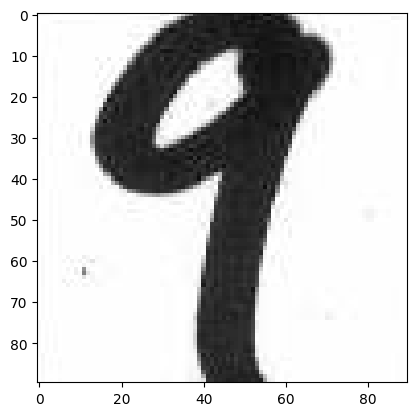

In [ ]:
print(extraRaw[19].shape) # look at the "19" on the second row
plt.show()
plt.imshow(extraRaw[19],cmap='gray')
plt.show()
# now we can see that the resolution is 90*90 = 8100
# we need to change it to 8*8 = 64 pixels to match with our training data

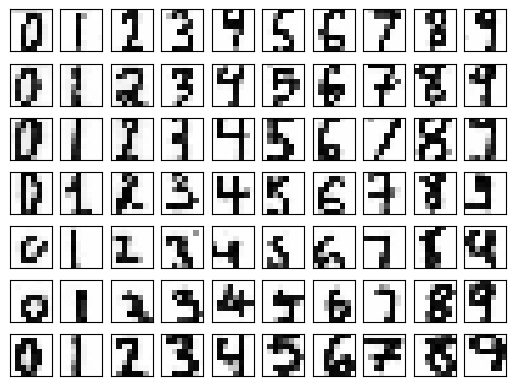

(70, 8, 8)


In [ ]:
# resize from 90*90 to 8*8

Rare = []
for i in range(70):
  Rare.append(cv2.resize(extraRaw[i], (8,8)))

Rare = np.array(Rare) # save as np arry

# Plot Rare
fig, axs = plt.subplots(nrows=7, ncols=10)
for i, ax in enumerate(axs.flat):
    ax.imshow(Rare[i],cmap='gray')
    ax.set_yticks([])
    ax.set_xticks([])

plt.show()

# looks not too bad, but I already can't tell what is what
print(Rare.shape)

In [ ]:
# reshape to 2D array to match the training data(from sklearn.datasets.load_digits) for our classifier
Rare = Rare.reshape(Rare.shape[0],-1)
print(Rare.shape)
print(Rare[0])

(70, 64)
[228 222 221 220 222 239 241 248 254 254 253  71  65  95 254 254 254 255
 252  72 241  64 250 254 254 254  76 220 250  64 241 254 254 255  73 246
 248  64 244 254 254 254  68 242 245  71 246 254 254 252  62 240  67  81
 248 254 254 254  82  60  75 251 250 254]


# training neural network classifier

In [ ]:
from sklearn.datasets import load_digits # get training data come from here
from sklearn import neural_network
from sklearn import metrics  # for confusion matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [ ]:
X,y = load_digits(return_X_y=True)  # load training data

# Do a crude test/train split to evaluate classifiers
NUM_TEST = 100
X_train = X[:-NUM_TEST] # use these for training
y_train = y[:-NUM_TEST]
X_test = X[-NUM_TEST:]  # use these for testing
y_test = y[-NUM_TEST:]  # the right answers to check classifier's performance

print("Data:  ",X.shape,y.shape)
print("Train: ",X_train.shape, y_train.shape)
print("Test:  ",X_test.shape,y_test.shape)

Data:   (1797, 64) (1797,)
Train:  (1697, 64) (1697,)
Test:   (100, 64) (100,)


In [ ]:
X_test[0]

array([ 0.,  0.,  7., 12., 13.,  2.,  0.,  0.,  0.,  0., 14., 13.,  8.,
       13.,  0.,  0.,  0.,  3., 16.,  1.,  0., 11.,  2.,  0.,  0.,  4.,
       14.,  0.,  0.,  5.,  8.,  0.,  0.,  5.,  8.,  0.,  0.,  5.,  8.,
        0.,  0.,  4., 16.,  0.,  2., 14.,  7.,  0.,  0.,  2., 16., 10.,
       14., 15.,  1.,  0.,  0.,  0.,  6., 14., 14.,  4.,  0.,  0.])

In [ ]:

#scale the Rare data using MinMaxScaler

scalerMM = MinMaxScaler(feature_range=(0, 15))
mediumRare = 15-scalerMM.fit_transform(Rare)


print(X_test[0])
print(mediumRare[6])


[ 0.  0.  7. 12. 13.  2.  0.  0.  0.  0. 14. 13.  8. 13.  0.  0.  0.  3.
 16.  1.  0. 11.  2.  0.  0.  4. 14.  0.  0.  5.  8.  0.  0.  5.  8.  0.
  0.  5.  8.  0.  0.  4. 16.  0.  2. 14.  7.  0.  0.  2. 16. 10. 14. 15.
  1.  0.  0.  0.  6. 14. 14.  4.  0.  0.]
[ 5.55555556e-01  7.77202073e-02  2.92682927e-01  1.40909091e+01
  1.43250000e+01  1.46954315e+01  7.65306122e-02  9.37500000e-01
  8.33333333e-02  7.50000000e-02  1.41624365e+01  1.39393939e+01
  5.25000000e-01  1.30964467e+01  2.30769231e-01  0.00000000e+00
  8.19672131e-02  7.57575758e-02  1.40862944e+01  7.53768844e-02
  1.77635684e-15  7.42574257e-02  7.97872340e-02  1.77635684e-15
  8.06451613e-02  7.46268657e-01  1.38578680e+01  7.53768844e-02
  7.46268657e-02  7.53768844e-02  7.73195876e-02  8.10810811e-02
  8.02139037e-02  1.31725888e+01  1.22864322e+01  3.76884422e-01
  1.48514851e-01  7.61421320e-02  7.81250000e-02  8.15217391e-02
  7.81250000e-02  5.23076923e+00  1.50000000e+01  1.43969849e+01
  1.42753623e+01  1.3425

In [ ]:
'''
# sclae data
scaler = StandardScaler()

scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
# apply same transformation to test data
X_test_scaled = scaler.transform(X_test)
medium = scaler.transform(mediumRare)

#print(X_test_scaled[0],'\n')
#print(mediumRare[0])
#print(medium[0])
'''

"\n# sclae data\nscaler = StandardScaler()  \n\nscaler.fit(X_train)  \nX_train_scaled = scaler.transform(X_train)  \n# apply same transformation to test data\nX_test_scaled = scaler.transform(X_test) \nmedium = scaler.transform(mediumRare)\n\n#print(X_test_scaled[0],'\n')\n#print(mediumRare[0])\n#print(medium[0])\n"

In [ ]:
# train neural network classifier
clf = neural_network.MLPClassifier(hidden_layer_sizes=(120),max_iter=1000, random_state=20)
clf.fit(X_train,y_train)

print("training score",clf.score(X_train,y_train))
score = clf.score(X_test,y_test)
print("testing score",score)


training score 1.0
testing score 0.96


In [ ]:
result = clf.predict(mediumRare)
print(result,"\n")
#print(clf.predict(medium))

[0 1 2 3 1 5 6 7 7 9 4 5 2 3 9 5 4 7 8 9 3 1 2 4 9 5 2 7 8 3 0 1 2 3 4 5 4
 3 3 4 4 5 4 1 4 4 4 1 5 4 6 1 1 9 4 4 6 9 8 3 4 1 2 3 8 5 5 7 9 9] 



# Test

In [ ]:
answer = [0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9]
answer = np.array(answer)
print(answer)

[0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6
 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9]


In [ ]:
clf.score(mediumRare,answer)

0.5142857142857142